In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Generate Beam-Free Map

In [2]:
# dipole_map = hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/commander/dipole_CMB_n4096_K.fits',field=0)
# npipe = hp.ud_grade(1e-6*hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/commander/data_rc1_temperature/cmb_Commander_npipe6v20.fits',field=0)-dipole_map,2048)
# del dipole_map

# pars = camb.CAMBparams()
# pars.set_cosmology(H0=67.32, ombh2=0.022383, omch2=0.12011,tau=0.0543,mnu=0.06,omk=0,standard_neutrino_neff=True)
# back = camb.get_background(pars)
# eta_rec = back.tau_maxvis # comoving horizon at last-scattering
# eta_0 = back.tau0 # comoving horizon today
# chi_rec = eta_0-eta_rec # distance to comoving horizon

# res = camb.get_results(pars)

# cl = res.get_cmb_power_spectra(raw_cl=True,CMB_unit='K')

# cl_npipe = hp.anafast(npipe)

# sim_map = hp.synfast(cl['total'][:,0],2048,pol=False)

# hp.write_map('/mnt/home/ophilcox/ceph/planck_npipe/cv_sim.fits',sim_map)

In [3]:
import numpy as np, szifi, healpy as hp, sys, os
import matplotlib.pyplot as plt

def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

test = is_interactive()
analysis_type = 'soubhik'

if test:
    batch_no = 699
    batch_size = 1
else:
    batch_no = int(sys.argv[1])
    batch_size = 10
    assert batch_no <= (768//batch_size+1)*batch_size
    
# Check if already computed!
if os.path.exists('outputs_planck/planck_batch%d_%s.npy'%(batch_no,analysis_type)) and not test:
    print("Output already computed; exiting!")
    sys.exit()

### PARAMETERS
params_szifi = szifi.params_szifi_default
params_data = szifi.params_data_default
params_model = szifi.params_model_default

# Data paths
params_szifi['path'] = '/mnt/home/ophilcox/szifi/'
if analysis_type =='point':
    cutout_dir = '/mnt/home/ophilcox/ceph/szifi_cutouts/planck_raw/'
else:
    cutout_dir = '/mnt/home/ophilcox/ceph/szifi_cutouts/planck_cleaned/'
if not os.path.exists(cutout_dir): os.makedirs(cutout_dir)
params_szifi['path_data'] = cutout_dir 

# Fields
params_data["field_ids"] = np.arange(batch_no*batch_size,min([(batch_no+1)*batch_size,768]))
params_data['data_set'] = 'Planck_pr4'

import camb
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.32, ombh2=0.022383, omch2=0.12011,tau=0.0543,mnu=0.06,omk=0,standard_neutrino_neff=True)
back = camb.get_background(pars)
eta_rec = back.tau_maxvis # comoving horizon at last-scattering
eta_0 = back.tau0 # comoving horizon today
chi_rec = eta_0-eta_rec # distance to comoving horizon

# Fitting range
theta_500 = np.geomspace(0.5,15.,15)
all_eta_star = np.geomspace(10,1000,10)

eta_stars = []
eta_hss = []
for i in range(len(all_eta_star)):
    chi_HSs = np.linspace(max(chi_rec-all_eta_star[i],0),min(chi_rec+all_eta_star[i],eta_0),12)[1:-1]
    eta_HSs = eta_0-chi_HSs
    for j in range(len(eta_HSs)):
        eta_stars.append(all_eta_star[i])
        eta_hss.append(eta_HSs[j])
eta_stars = np.asarray(eta_stars)
eta_hss = np.asarray(eta_hss)
        
if test:
    eta_stars = np.asarray([27.82559402])
    eta_hss = np.asarray([257.65874426])
    #eta_hss = eta_hss[:2]
    #theta_500 = theta_500[:2]

params_szifi['theta_500_vec_arcmin'] = theta_500
params_szifi['eta_star_vec'] = eta_stars
params_szifi['eta_hs_vec'] = eta_hss

if analysis_type=='arnaud':
    params_szifi['iterative'] = True
    params_szifi['lrange'] = [100,2500]
else:
    params_szifi['iterative'] = False
    params_szifi['lrange'] = [30,3000]

# Other parameters
params_szifi['inpaint'] = True
params_szifi['deproject_cib'] = None
params_szifi['estimate_spec'] = 'estimate'

# SNR threshold
params_szifi['q_th'] = 4.0
params_szifi['q_th_noise'] = 4.0

# Optionally save SNR maps
params_szifi['save_snr_maps'] = True
if not os.path.exists(cutout_dir+'snr_maps/'): os.makedirs(cutout_dir+'snr_maps/')
params_szifi['snr_maps_path'] = cutout_dir+'snr_maps/'
params_szifi['snr_maps_name'] = 'planck_visual%d'%batch_no

nx = 1024
l = 14.8

n_tiles = 768
nside_tile = 8

### MAKE CUTOUTS
def get_cutout(inp_map, i):
    plt.ioff()
    lon,lat = hp.pix2ang(nside_tile,i,lonlat=True)
    cutout = szifi.get_cutout(inp_map,[lon,lat],nx,l)
    plt.close()
    plt.ion()
    return cutout

def get_tilemap(i):
    """Compute tiling map for a given pixel center"""
    
    smap = np.zeros(hp.nside2npix(nside_tile))
    smap[i] = 1
    umap = hp.ud_grade(smap, 2048)
    return get_cutout(umap, i)

In [4]:
# Test if cutouts exist
all_exist = True
for i in params_data['field_ids']:
    if not os.path.exists(cutout_dir+"planck_field_" + str(i) + "_tmap.npy"): all_exist=False
    if not os.path.exists(cutout_dir+"planck_field_" + str(i) + "_mask.npy"): all_exist=False

if all_exist:
    print("Using precomputed cutouts")
    
else:
    print("Loading Planck data")

    # Parameters
    sim_dir = '/mnt/home/ophilcox/ceph/planck_pr4_freq/'
    freqs = ['100','143','217','353','545','857']

    # Load dipole
    dipole_map = hp.ud_grade(hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/commander/dipole_CMB_n4096_K.fits',field=[0]),2048)

    # Load frequency maps
    print("Loading frequency maps")
    freq_maps = []
    for f in range(len(freqs)):
        freq_maps.append(hp.read_map(sim_dir+'planck/npipe6v20_%s_map.fits'%(freqs[f]),field=0)-dipole_map)

    # Load point-source mask
    planck_dir = '/mnt/home/ophilcox/ceph/planck_pr3_raw/'
    if analysis_type != 'point':
        print("Loading point mask")
        all_point = hp.ud_grade(hp.read_map(sim_dir+'planck/point_mask_snr10.fits'),2048)

    # Load galactic mask (ordering: {20,40,60,70,80,90,97,99}%)
    gal_map = hp.read_map(planck_dir+'HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=5)

    print("Generating cutouts")
    for i in params_data['field_ids']:
        print("On tile %d"%i)

        # Compute frequency cutouts
        freq_cutouts = [get_cutout(freq_maps[freq_index], i) for freq_index in range(len(freqs))]
        freq_output = np.asarray([np.stack(freq_cutouts,axis=-1)])
        np.save(cutout_dir+"planck_field_" + str(i) + "_tmap.npy",freq_output)

        # Compute mask cutouts
        tile_cutout = get_tilemap(i)
        gal_cutout = get_cutout(gal_map, i)
        if analysis_type!='point':
            point_cutout = get_cutout(all_point, i)
        else:
            point_cutout = 1.+0.*gal_cutout
        mask_output = np.stack([gal_cutout, point_cutout, tile_cutout])
        
        np.save(cutout_dir+"planck_field_" + str(i) + "_mask.npy",mask_output)
        
# Now define dataset
data = szifi.input_data(params_szifi=params_szifi,params_data=params_data)

Using precomputed cutouts


KeyboardInterrupt: 

In [ ]:
print("\n\n## Profile: %s"%analysis_type)
params_model['profile_type'] = analysis_type
assert len(params_szifi['freqs'])==6

cluster_finder = szifi.cluster_finder(params_szifi=params_szifi,params_model=params_model,data_file=data,rank=0)
cluster_finder.find_clusters()

results = cluster_finder.results_dict
detection_processor = szifi.detection_processor(results,params_szifi,params_model['profile_type'])

if analysis_type=='arnaud':
    try:
        catalogue = detection_processor.results.catalogues["catalogue_find_1"]
    except KeyError:
        catalogue = szifi.cat.cluster_catalogue()
else:
    try:
        catalogue = detection_processor.results.catalogues["catalogue_find_0"]
    except KeyError:
        catalogue = szifi.cat.cluster_catalogue()

q_th_final = 4.
try:
    catalogue = szifi.get_catalogue_q_th(catalogue,q_th_final)
except TypeError:
    catalogue = szifi.cat.cluster_catalogue()

if not test: np.save('outputs_planck/planck_batch%d_%s.npy'%(batch_no,analysis_type),catalogue)

### Load Planck map and compute power spectra

In [202]:
# Input files
Nside = 512

# Load common mask
mask = hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits')

injection = hp.read_map('/mnt/home/ophilcox/ceph/szifi_cutouts/cutout300_v2_sim0_sep.fits')
mask_lr = hp.ud_grade(mask,Nside)
injection_lr = hp.ud_grade(injection*mask,Nside)/np.sqrt(np.mean(mask_lr))
    
Cl_raw = []
Cl_cross = []
for sim_no in range(10):
    print("Loading component-separation map %d"%sim_no)
    compsep = hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/sevem/SEVEM_NPIPE_sims/SEVEM_NPIPE_cmb_sim%s.fits'%(str(sim_no+200).zfill(4)))+hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/sevem/SEVEM_NPIPE_sims/SEVEM_NPIPE_noise_sim%s.fits'%(str(sim_no+200).zfill(4)))
        
    compsep_lr = hp.ud_grade(compsep*mask,Nside)/np.sqrt(np.mean(mask_lr))
        
    Cl_raw.append(hp.anafast(compsep_lr))
    #Cl_cross.append(hp.anafast(compsep_lr, injection_lr))

Cl_raw = np.asarray(Cl_raw)
#Cl_cross = np.asarray(Cl_cross)

Loading component-separation map 0
Loading component-separation map 1
Loading component-separation map 2
Loading component-separation map 3
Loading component-separation map 4
Loading component-separation map 5
Loading component-separation map 6
Loading component-separation map 7
Loading component-separation map 8
Loading component-separation map 9


In [203]:
data = szifi.input_data(params_szifi=params_szifi,params_data=params_data)

all_eta_star = np.geomspace(10,1000,10)
inj_cat = np.load('injection300_v2_sim0.npz')
lon = inj_cat['lon']
lat = inj_cat['lat']

xymap = np.meshgrid(np.arange(-data.nx/2,data.nx/2)*data.dx,np.arange(-data.nx/2,data.nx/2)*data.dx)
dismap = np.sqrt(xymap[0]**2+xymap[1]**2)
inds = np.argsort(dismap.ravel())[::-1]   
from scipy.interpolate import interp1d
    
tem_interps = []
max_dis = []
for i in range(len(all_eta_star)):
    this_eta_star = all_eta_star[i]
    this_eta_hs = eta_rec
    
    png_model = szifi.model.png({'eta_star':this_eta_star,'eta_hs':this_eta_hs},kmin=1e-6,kmax=1,lmax=3500,reduce_k=20,type="soubhik")

    data = szifi.input_data(params_szifi=params_szifi,params_data=params_data)

    t_tem = png_model.get_t_map_convolved(data.pix,data.data['experiment'], theta_misc=[0.-data.dx/2,0-data.dx/2],beam='real', get_nc=False,sed=None)
    rel_t = np.abs(t_tem[:,:,0]/np.max(np.abs(t_tem[:,:,0]))).ravel()
    thresh = 1e-3
    while True:
        try:
            dis_max = dismap.ravel()[inds][np.where(np.diff(rel_t[inds]<thresh))[0][0]]
            break
        except IndexError:
            thresh *= 1.1
    print(thresh)
    
    tem_interps.append(interp1d(dismap[dismap<dis_max],np.asarray([t_tem[:,:,j][dismap<dis_max] for j in range(1)]), fill_value=0, bounds_error=False))
    max_dis.append(dis_max)
    print("0.1%% scale: %.3f radians"%dis_max)

Maximum scale: 0.100 radians
0.001
0.1% scale: 0.024 radians
Maximum scale: 0.100 radians
0.001
0.1% scale: 0.024 radians
Maximum scale: 0.100 radians
0.001
0.1% scale: 0.025 radians
Maximum scale: 0.100 radians
0.001
0.1% scale: 0.026 radians
Maximum scale: 0.100 radians
0.001
0.1% scale: 0.030 radians
Maximum scale: 0.100 radians
0.001
0.1% scale: 0.033 radians
Maximum scale: 0.100 radians
0.001
0.1% scale: 0.037 radians
Maximum scale: 0.100 radians
0.001
0.1% scale: 0.050 radians
Maximum scale: 0.150 radians
0.001
0.1% scale: 0.070 radians
Maximum scale: 0.250 radians
0.001
0.1% scale: 0.104 radians


In [236]:
nside = 512

Cl_hots = []

# Add all profiles of a given size
for eta_ind in range(10):
    print("On eta %d"%eta_ind)
    template_map = np.zeros((hp.nside2npix(nside), 1))
    ct = 0
    for profile_id in range(len(lon)):
        if inj_cat['eta_stars'][profile_id]!=all_eta_star[eta_ind]: continue
        ct += 1
        #if ct>=15: continue
        
        #if profile_id%10==0: print("Adding profile %d"%profile_id)
        n_close = 0
        close_pix = hp.ang2pix(nside, lon[profile_id], lat[profile_id], lonlat=True)
        for i in range(500):
            close_pix = np.unique(np.concatenate([np.asarray(close_pix).ravel(),
                                                  hp.get_all_neighbours(nside, close_pix).ravel()]))
            close_pix = close_pix[close_pix!=-1]
            
            # Check distances
            dis = hp.rotator.angdist(hp.pix2ang(nside, close_pix, lonlat=True), (lon[profile_id], lat[profile_id]), lonlat=True)
            eta_ind = np.where(inj_cat['eta_stars'][profile_id]==all_eta_star)[0][0]
            if n_close==np.sum(dis<max_dis[eta_ind]): break
            n_close = np.sum(dis<max_dis[eta_ind])
            if i==499: print("Not all neighbors found!")

        template_map[close_pix,:] += tem_interps[eta_ind](dis).T
        
    Cl_hots.append(hp.anafast(template_map[:,0]*hp.ud_grade(mask,nside))/np.sqrt(np.mean(hp.ud_grade(mask,nside))))

On eta 0
On eta 1
On eta 2
On eta 3
On eta 4
On eta 5
On eta 6
On eta 7
On eta 8
On eta 9


### the template-map is in $\mu K$ already!!

### check what units the data map is in!!

In [238]:
l = np.arange(len(Cl_raw[0]))
Cl_err = 1./np.sqrt(np.mean(mask))*np.sqrt(2./(2.*l+1))*np.mean(Cl_raw,0)

### Computing spectra without $10^{-6}$ scaling and for $30$ hotspots at once!

### note that for Cl we care about the *number* injected, unlike usually

In [240]:
g_vals = np.logspace(-1,8,10000)
Ns = 1
g_crit = [g_vals[np.where([np.sum((Cl_hots[e]/30.*Ns*(gg*1e-6)**2)**2/np.var(Cl_raw,0))>25. for gg in g_vals])[0][0]] for e in range(10)]

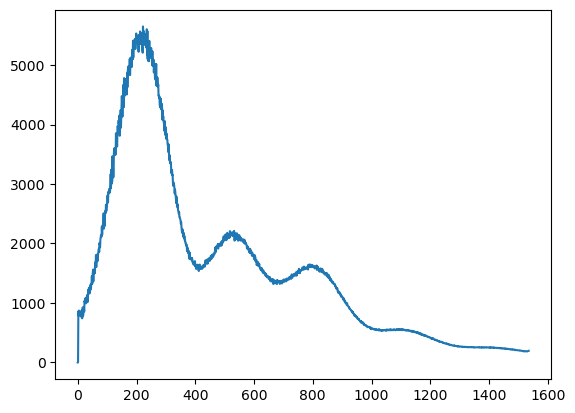

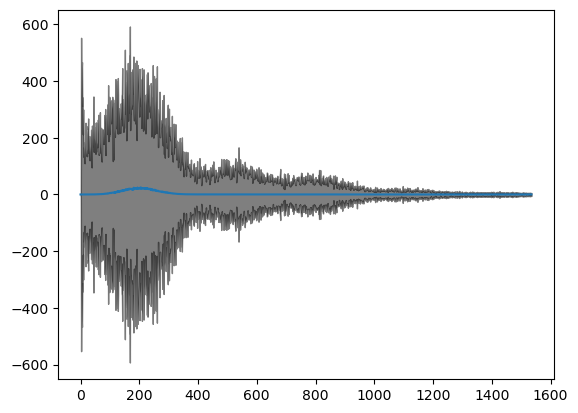

In [247]:
sc = l*(l+1)/(2.*np.pi)*1e12
plt.plot(l,np.mean(Cl_raw,0)*sc)
plt.figure()
plt.plot(l,Cl_hots[6]/30.*1162.*(1.*2.73*1e-6)**2*sc/2.73**2)
plt.fill_between(l,-np.std(Cl_raw,0)*sc,np.std(Cl_raw,0)*sc,color='k',alpha=0.5)

In [248]:
np.sum((Cl_hots[5]/30.*16.*(6.*2.73*1e-6)**2)**2/np.var(Cl_raw,0))

0.4987066783493095

In [249]:
all_eta_star[5]

129.1549665014884

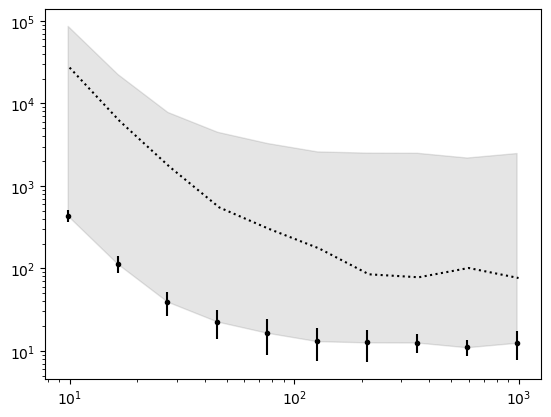

In [250]:
plt.plot(all_eta_star,g_crit,ls=':',c='k')
plt.errorbar(all_eta_star*0.98, 5*np.asarray(sigs), yerr=5.*np.asarray(errs), alpha=1, label=r'$5\,\sigma(g)$', ls='',marker='.', c='k')
plt.fill_between(all_eta_star*0.98,5*np.asarray(sigs),1000.*np.asarray(sigs),alpha=0.1,color='k')
plt.xscale('log')
plt.yscale('log')

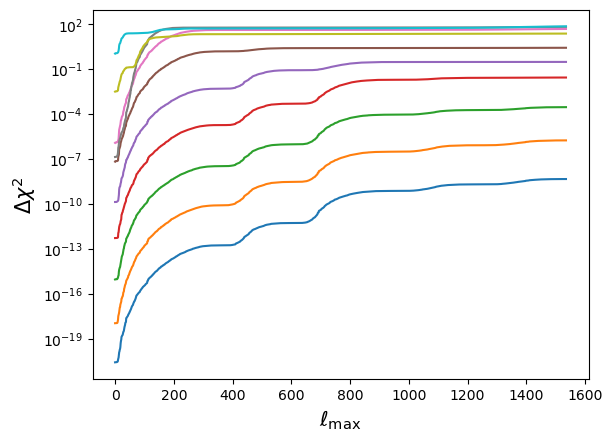

In [ ]:
g = 100
for e in range(10):
    plt.plot(l,np.cumsum((Cl_hots[e]/30.*(g*1e-6)**2)**2/np.var(Cl_raw,0)))
plt.xlabel(r'$\ell_{\rm max}$',fontsize=15);
plt.ylabel(r'$\Delta\chi^2$',fontsize=15);
plt.yscale('log')

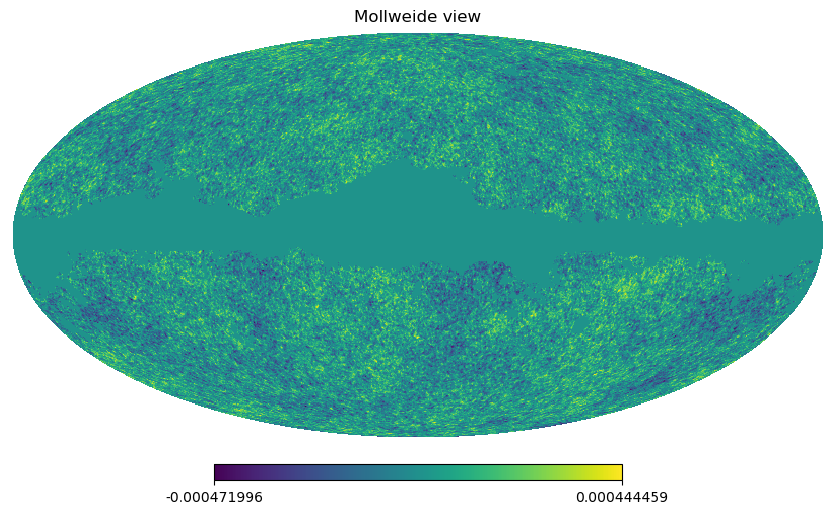

In [ ]:
hp.mollview((compsep+injection*1e-6*2.73)*mask)

## Point-Source Analysis

In [119]:
def load_point_catalog(snr_min=10):

    all_cat = []
    for freq in range(6):
        i = 0
        for batch in range(800):
            try:
                if i==0:
                    tot_cat = np.load('outputs_planck/planck_batch%d_point.npy'%(batch),allow_pickle=True)[freq]
                    i += 1
                else:
                    tot_cat.append(np.load('outputs_planck/planck_batch%d_point.npy'%(batch),allow_pickle=True)[freq])
                    i += 1
            except IOError:
                #print(batch)
                continue
            
        if i!=0:
            print("\nFound %d point sources in freq-%d from %d catalogues"%(len(tot_cat.catalogue['q_opt']),freq,i))
            
        # Cut to SNR of 10
        tot_cat = szifi.get_catalogue_q_th(tot_cat, snr_min)
        print("Found %d point sources in freq-%d clusters after SNR=%.1f cut"%(len(tot_cat.catalogue['q_opt']),freq,snr_min))

        all_cat.append(tot_cat)
        
    return all_cat

point_cat = load_point_catalog(snr_min=10)


Found 3066 point sources in freq-0 from 770 catalogues
Found 452 point sources in freq-0 clusters after SNR=10.0 cut

Found 5524 point sources in freq-1 from 770 catalogues
Found 827 point sources in freq-1 clusters after SNR=10.0 cut

Found 14264 point sources in freq-2 from 770 catalogues
Found 2175 point sources in freq-2 clusters after SNR=10.0 cut

Found 18855 point sources in freq-3 from 770 catalogues
Found 2632 point sources in freq-3 clusters after SNR=10.0 cut

Found 26871 point sources in freq-4 from 770 catalogues
Found 2951 point sources in freq-4 clusters after SNR=10.0 cut

Found 37547 point sources in freq-5 from 770 catalogues
Found 4046 point sources in freq-5 clusters after SNR=10.0 cut


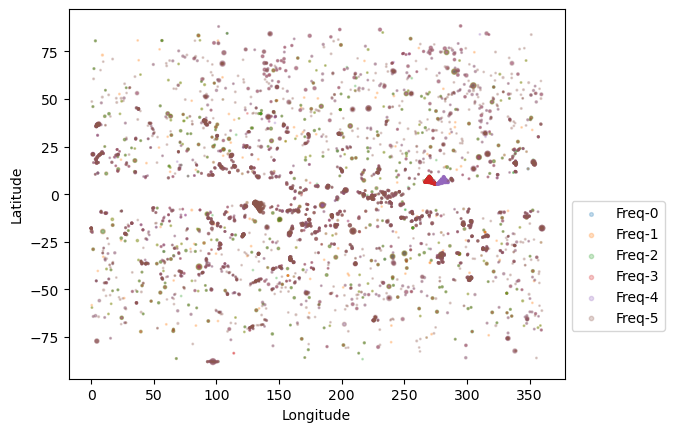

In [120]:
ssig = 10

for i in range(6):
    cat = point_cat[i]
    lat = cat.catalogue['lat'][cat.catalogue['q_opt']>ssig]
    lon = cat.catalogue['lon'][cat.catalogue['q_opt']>ssig]
    snr = cat.catalogue['q_opt'][cat.catalogue['q_opt']>ssig]

    plt.scatter(lon,lat,s=(snr/ssig)**1,alpha=0.25,label='Freq-%d'%i)#np.exp(psnr/5))
plt.xlabel(r'Longitude')
plt.ylabel(r'Latitude')
plt.legend(bbox_to_anchor=(1.,0.5),ncol=1);

In [121]:
# nside = 4096
# maskmap = np.ones(hp.nside2npix(nside))

# params_szifi['freqs'] = np.arange(6)
# data = szifi.input_data(params_szifi=params_szifi,params_data=params_data)

# for f in range(6):
    
#     theta_beam = data.data['experiment'].FWHM[f]/(2.*np.sqrt(2.*np.log(2)))*np.pi/180./60. # beam width in radians
#     print("Frequency %d, theta %.1f"%(f,theta_beam*60.*180./np.pi))
    
#     # Find healpix IDs of nearest pixels and mask them
#     lon, lat = hp.pix2ang(nside, hp.ang2pix(nside, point_cat[f].catalogue['lon'],point_cat[f].catalogue['lat'], lonlat=True), lonlat=True)
#     maskmap[hp.ang2pix(nside, lon, lat, lonlat=True)] = 0
    
#     # Find neighbors
#     neighbors = np.unique(hp.get_all_neighbours(nside, lon, lat, lonlat=True))
#     neighbors = neighbors[neighbors!=-1]
#     all_angs = hp.pix2ang(nside, neighbors,lonlat=True)

#     all_sin_lat = np.sin(all_angs[1]*np.pi/180.)
#     all_cos_lat = np.cos(all_angs[1]*np.pi/180.)
#     all_sin_lon = np.sin(all_angs[0]*np.pi/180.)
#     all_cos_lon = np.cos(all_angs[0]*np.pi/180.)

#     def dis_all(lon,lat):
#         sin_lat = np.sin(lat*np.pi/180.)[None,:]
#         cos_lat = np.cos(lat*np.pi/180.)[None,:]
#         sin_lon = np.sin(lon*np.pi/180.)[None,:]
#         cos_lon = np.cos(lon*np.pi/180.)[None,:]

#         return np.arccos(sin_lat*all_sin_lat[:,None]+cos_lat*all_cos_lat[:,None]*(cos_lon*all_cos_lon[:,None]+sin_lon*all_sin_lon[:,None]))

#     dis = dis_all(lon,lat)
#     close_points = np.min(dis,axis=1)<3*theta_beam

#     # Define neighboring pixels in mask
#     good_pix = neighbors[close_points]
    
#     print(len(good_pix))

#     old_ct = len(good_pix)
#     for _ in range(10):
#         neighbors = np.unique(hp.get_all_neighbours(nside, good_pix))
#         neighbors = neighbors[neighbors!=-1]

#         good_count = np.bincount(good_pix,minlength=hp.nside2npix(nside))
#         neigh_count = np.bincount(neighbors,minlength=hp.nside2npix(nside))
#         neighbors = np.where((neigh_count!=0)*(good_count==0))[0]
        
#         all_angs = hp.pix2ang(nside, neighbors,lonlat=True)

#         all_sin_lat = np.sin(all_angs[1]*np.pi/180.)
#         all_cos_lat = np.cos(all_angs[1]*np.pi/180.)
#         all_sin_lon = np.sin(all_angs[0]*np.pi/180.)
#         all_cos_lon = np.cos(all_angs[0]*np.pi/180.)

#         def dis_all(lon,lat):
#             sin_lat = np.sin(lat*np.pi/180.)[None,:]
#             cos_lat = np.cos(lat*np.pi/180.)[None,:]
#             sin_lon = np.sin(lon*np.pi/180.)[None,:]
#             cos_lon = np.cos(lon*np.pi/180.)[None,:]

#             return np.arccos(sin_lat*all_sin_lat[:,None]+cos_lat*all_cos_lat[:,None]*(cos_lon*all_cos_lon[:,None]+sin_lon*all_sin_lon[:,None]))

#         dis = dis_all(lon,lat)
#         close_points = np.min(dis,axis=1)<3*theta_beam

#         good_count[neighbors[close_points]] += 1
#         good_pix = np.where(good_count!=0)[0]
#         if old_ct == len(good_pix): break
#         old_ct = len(good_pix)
#         print(len(good_pix))

#     maskmap[good_pix] = 0
# print("Complete!")

# sim_dir = '/mnt/home/ophilcox/ceph/planck_pr4_freq/'
# hp.write_map(sim_dir+'planck/point_mask_snr10.fits',maskmap,overwrite=True)

## SZ Analysis

In [122]:
def load_sz_catalog():

    i = 0
    for batch in range(800):
        try:
            if i==0:
                tot_cat = np.load('outputs_planck/planck_batch%d_arnaud.npy'%(batch),allow_pickle=True).item()
                i += 1
            else:
                tot_cat.append(np.load('outputs_planck/planck_batch%d_arnaud.npy'%(batch),allow_pickle=True).item())
                i += 1
        except IOError:
            continue
    if i!=0:
        print("Found %d SZ clusters (SNR>4) from %d catalogues"%(len(tot_cat.catalogue['q_opt']),i))
    return tot_cat

# Cut to SNR of 5
snr_min = 4.5
sz_cat = szifi.get_catalogue_q_th(load_sz_catalog(), snr_min)
print("\nFound %d SZ clusters after SNR=%.1f cut"%(len(sz_cat.catalogue['q_opt']),snr_min))

Found 5433 SZ clusters (SNR>4) from 770 catalogues

Found 3538 SZ clusters after SNR=4.5 cut


In [123]:
sz_cat_merge = szifi.merge_detections(sz_cat,radius_arcmin=10,return_merge_flag=True,mode="fof")

print("\nFound %d SZ merged clusters"%len(sz_cat_merge.catalogue['q_opt']))


Found 2696 SZ merged clusters


### Check distance to point clusters

In [124]:
good_inds = []
for c in range(len(sz_cat_merge.catalogue['q_opt'])):
    clon = sz_cat_merge.catalogue['lon'][c]
    clat = sz_cat_merge.catalogue['lat'][c]
    
    bad = False
    for f in range(6):
        theta_beam = data.data['experiment'].FWHM[f]/(2.*np.sqrt(2.*np.log(2)))*np.pi/180./60. # beam width in radians

        cdis = hp.rotator.angdist((clon,clat),(point_cat[f].catalogue['lon'],point_cat[f].catalogue['lat']),lonlat=True)
        if np.min(cdis)<5*theta_beam: bad=True
        
    if not bad:
        good_inds.append(c)

sz_cat_nopoint = szifi.cat.get_catalogue_indices(sz_cat_merge, good_inds)
print("\nFound %d SZ clusters after point-source cut"%len(sz_cat_nopoint.catalogue['q_opt']))


Found 2695 SZ clusters after point-source cut


In [125]:
sz_mask = hp.read_map('COM_Mask_Compton-SZMap_2048_R2.00.fits')

In [126]:
from astropy.io import fits
snr_min = 5
sz_file = fits.open('HFI_PCCS_SZ-union_R2.08.fits')[1].data
sz_official = {'lon':sz_file['GLON'][sz_file['SNR']>snr_min], 'lat':sz_file['GLAT'][sz_file['SNR']>snr_min],'snr':sz_file['SNR'][sz_file['SNR']>snr_min]}

### Hotspot analysis

In [127]:
def load_png_catalog(sep='none'):
    i = 0
    for batch in range(800):
        if sep=='sevem':
            name = 'outputs_planck/planck_sep_batch%d_soubhik.npy'%(batch)
        elif sep=='commander':
            name = 'outputs_planck/planck_sepC_batch%d_soubhik.npy'%(batch)
        elif sep=='none':
            name = 'outputs_planck/planck_batch%d_soubhik.npy'%(batch)
        elif sep=='cv':
            name = 'outputs_cv/cv_sep_batch%d_soubhik.npy'%(batch)
        try:
            if i==0:
                if 'eta_star' in np.load(name,allow_pickle=True).item().catalogue.keys():
                    tot_cat = np.load(name,allow_pickle=True).item()
                    i += 1
                else:
                    continue
            else:
                try:
                    tot_cat.append(np.load(name,allow_pickle=True).item())
                except KeyError:
                    pass;
                    #print("Key: %s"%batch)
                i += 1
        except IOError:
            #print(batch)
            continue
    if i!=0:
        print("Found %d PNG hotspots (SNR>4) from %d catalogues"%(len(tot_cat.catalogue['q_opt']),i))
    return tot_cat

# Cut to SNR of 4
snr_min = 5
png_cat = szifi.get_catalogue_q_th(load_png_catalog('none'), snr_min)
png_cat_sep = szifi.get_catalogue_q_th(load_png_catalog('sevem'), snr_min)
png_cat_sepC = szifi.get_catalogue_q_th(load_png_catalog('commander'), snr_min)

Found 42973 PNG hotspots (SNR>4) from 770 catalogues
Found 8035 PNG hotspots (SNR>4) from 770 catalogues
Found 7108 PNG hotspots (SNR>4) from 769 catalogues


In [128]:
# gal70 = hp.read_map('/mnt/home/ophilcox/ceph/planck_pr3_raw/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=3)

# compsep = hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits')

# inp_mask = hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/COM_Mask_CMB-Inpainting-Mask-Int_2048_R3.00.fits')

# point_mask = hp.read_map('/mnt/home/ophilcox/ceph/planck_pr3_raw/HFI_Mask_PointSrc_2048_R2.00.fits')

# from astropy.io import fits
# snr_min = 5
# # non-thermal sources
# nt_file = fits.open('COM_PCCS_PCNT_R2.00.fits')[1].data
# nt_official = {'lon':nt_file['GLON'], 'lat':nt_file['GLAT']}

# gal40 = hp.read_map('/mnt/home/ophilcox/ceph/planck_pr3_raw/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=1)
# gal60 = hp.read_map('/mnt/home/ophilcox/ceph/planck_pr3_raw/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=2)

# lens_mask = hp.read_map('COM_Mask_Lensing_2048_R2.00.fits')

In [129]:
compsep = hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits')
inp_mask = hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/COM_Mask_CMB-Inpainting-Mask-Int_2048_R3.00.fits')

In [130]:
def remove_point_sources(input_cat, exclusion_factor=5):
    good_inds = []
    for c in range(len(input_cat.catalogue['q_opt'])):
        clon = input_cat.catalogue['lon'][c]
        clat = input_cat.catalogue['lat'][c]

        bad = False
        for f in range(6):
            theta_beam = data.data['experiment'].FWHM[f]/(2.*np.sqrt(2.*np.log(2)))*np.pi/180./60. # beam width in radians

            cdis = hp.rotator.angdist((clon,clat),(point_cat[f].catalogue['lon'],point_cat[f].catalogue['lat']),lonlat=True)
            if np.min(cdis)<exclusion_factor*theta_beam: bad=True

        if not bad:
            good_inds.append(c)

    return szifi.cat.get_catalogue_indices(input_cat, good_inds)

def remove_cat(input_cat, removal_cat, dis_arcmin=10):
    good_inds = []
    for c in range(len(input_cat.catalogue['q_opt'])):
        clon = input_cat.catalogue['lon'][c]
        clat = input_cat.catalogue['lat'][c]

        cdis = hp.rotator.angdist((clon,clat),(removal_cat['lon'],removal_cat['lat']),lonlat=True)
        if not np.min(cdis)<dis_arcmin*np.pi/180./60.:
            good_inds.append(c)

    return szifi.cat.get_catalogue_indices(input_cat, good_inds)

def cut_on_map(input_cat, mask_map):
    return szifi.cat.get_catalogue_indices(input_cat, np.where(mask_map[hp.ang2pix(2048,input_cat.catalogue['lon'],input_cat.catalogue['lat'],lonlat=True)]))

def merge_cat(catalogue, size_factor=0.2,verb=True):
    
    len_pre = np.inf
    len_post = -1
    it = 0
    while len_pre!=len_post: 
        len_pre = len(catalogue.catalogue['q_opt'])
        catalogue = _merge_cat(catalogue, size_factor=size_factor, verb=verb)
        len_post = len(catalogue.catalogue['q_opt'])
        it +=1
    print('Finished in %d iterations'%it)
    return catalogue

def _merge_cat(catalogue,size_factor=0.2,verb=True):
    catalogue = szifi.cat.get_catalogue_indices(catalogue,np.where(catalogue.catalogue["q_opt"] != -1.)[0])
    n_clusters = len(catalogue.catalogue["q_opt"])
    catalogue_merged = szifi.cat.cluster_catalogue()
    catalogue_compare = catalogue

    i = 0

    indices_subtract = np.arange(len(catalogue_compare.catalogue["q_opt"]))
    merge_flags = np.zeros(0)

    while len(indices_subtract) > 0:

        catalogue_compare_new = szifi.cat.cluster_catalogue()

        for key in catalogue_compare.catalogue.keys():

            if len(catalogue_compare.catalogue[key]) > 0.:

                catalogue_compare_new.catalogue[key] = catalogue_compare.catalogue[key][indices_subtract]

        catalogue_compare = catalogue_compare_new

        n_clusters = len(catalogue_compare.catalogue["q_opt"])
        dist = szifi.sphere.get_angdist(catalogue_compare.catalogue["lon"][0]*np.ones(n_clusters),catalogue_compare.catalogue["lon"],
        catalogue_compare.catalogue["lat"][0]*np.ones(n_clusters),catalogue_compare.catalogue["lat"])
        
        dist_thresh = np.sqrt(4.*np.pi)*size_factor*(catalogue_compare.catalogue['eta_star'][0]+catalogue_compare.catalogue['eta_star'])/eta_0
        indices = np.where(dist <= dist_thresh)[0]
        merge_flags = np.append(merge_flags,len(indices))
        
        index_max = indices[np.argmax(catalogue_compare.catalogue["q_opt"][indices])]
        
        catalogue_new = szifi.cat.cluster_catalogue()

        for key in catalogue_compare.catalogue.keys():

            if len(catalogue_compare.catalogue[key]) > 0.:

                catalogue_new.catalogue[key] = np.array([catalogue_compare.catalogue[key][index_max]])

        catalogue_merged.append(catalogue_new,append_keys="new")
        
        indices_subtract = np.setdiff1d(np.arange(len(catalogue_compare.catalogue["q_opt"])),indices)
        
        i += 1

    if verb: print("Start size: %d, end size: %d"%(len(catalogue.catalogue['q_opt']),len(catalogue_merged.catalogue['q_opt'])))
    return catalogue_merged

def process_png(_png_cat, merge_factor=0.2, point_exclusion_factor=5, sz_radius=10):
    """Process a PNG catalogue, applying various cuts"""
    
    print("\nStarted with %d PNG hotspots"%len(_png_cat.catalogue['q_opt']))
    
    # Remove SZ mask
    png_cat = cut_on_map(_png_cat, sz_mask)
    print("Found %d PNG hotspots after SZ mask cut"%len(png_cat.catalogue['q_opt']))
    
    # Remove nearby point-sources
    png_cat = remove_point_sources(png_cat, exclusion_factor=point_exclusion_factor)
    print("Found %d PNG hotspots after point-source cut"%len(png_cat.catalogue['q_opt']))

    # Remove SZ sources
    png_cat = remove_cat(png_cat, sz_cat_nopoint.catalogue, dis_arcmin=sz_radius)
    print("Found %d PNG hotspots after SZ-source cut"%len(png_cat.catalogue['q_opt']))
    
    # # Remove official Planck SNR>5 SZ sources
    # png_cat = remove_cat(png_cat, sz_official, dis_arcmin=sz_radius)
    # print("Found %d PNG hotspots after official SZ-source cut"%len(png_cat.catalogue['q_opt']))

#     # Remove component-separated mask
#     png_cat = cut_on_map(png_cat, compsep)
#     print("Found %d PNG hotspots after component-separation map cut"%len(png_cat.catalogue['q_opt']))
    
#     # Remove inpainting mask
#     png_cat = cut_on_map(png_cat, inp_mask)
#     print("Found %d PNG hotspots after inpainting mask cut"%len(png_cat.catalogue['q_opt']))
    
#     # Remove point mask
#     png_cat = cut_on_map(png_cat, point_mask)
#     print("Found %d PNG hotspots after point mask cut"%len(png_cat.catalogue['q_opt']))

    # Remove non-thermal sources
    # png_cat = remove_cat(png_cat, nt_official, dis_arcmin=sz_radius)
    # print("Found %d PNG hotspots after non-thermal source cut"%len(png_cat.catalogue['q_opt']))
  
    # Merge sources
    #png_cat = szifi.merge_detections(png_cat,radius_arcmin=merge_radius,return_merge_flag=False,mode="closest")
    png_cat = merge_cat(png_cat,size_factor=merge_factor, verb=False)
    print("Found %d merged PNG hotspots"%len(png_cat.catalogue['q_opt']))
    
    # Return
    return png_cat

png_cat_proc = process_png(png_cat, merge_factor=0.5, point_exclusion_factor=5, sz_radius=10)
png_cat_proc_sep = process_png(png_cat_sep, merge_factor=0.5, point_exclusion_factor=5, sz_radius=10)
png_cat_proc_sepC = process_png(png_cat_sepC, merge_factor=0.5, point_exclusion_factor=5, sz_radius=10)


Started with 15112 PNG hotspots
Found 838 PNG hotspots after SZ mask cut
Found 838 PNG hotspots after point-source cut
Found 833 PNG hotspots after SZ-source cut
Finished in 4 iterations
Found 144 merged PNG hotspots

Started with 372 PNG hotspots
Found 87 PNG hotspots after SZ mask cut
Found 87 PNG hotspots after point-source cut
Found 84 PNG hotspots after SZ-source cut
Finished in 2 iterations
Found 48 merged PNG hotspots

Started with 411 PNG hotspots
Found 57 PNG hotspots after SZ mask cut
Found 57 PNG hotspots after point-source cut
Found 54 PNG hotspots after SZ-source cut
Finished in 2 iterations
Found 35 merged PNG hotspots


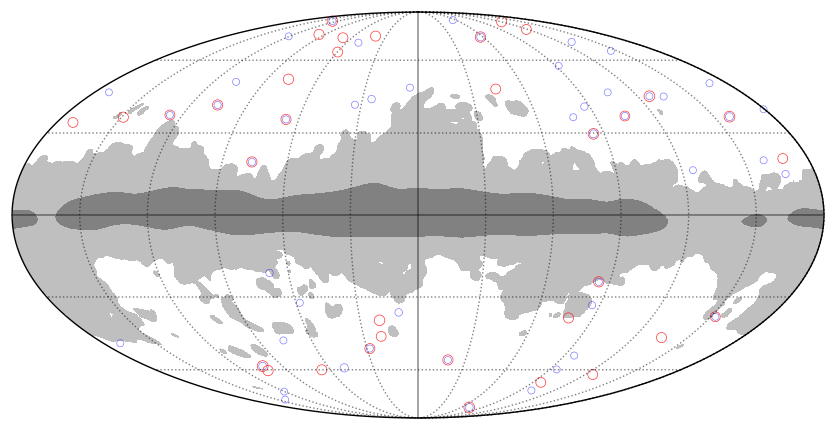

In [131]:
gal90 = hp.read_map('/mnt/home/ophilcox/ceph/planck_pr3_raw/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=5)

sz_cut = np.zeros(len(sz_mask),dtype=float)
sz_cut[gal90==0] = 50
sz_cut[(sz_mask==0)*(gal90!=0)] = 25
hp.mollview(sz_cut+gal90,max=100, #coord=["G", "E"],
            cmap=cm.gray_r,cbar=False,notext=True,title='')
hp.graticule(dpar=30.,dmer=30.,alpha=0.5)

cval = png_cat_proc.catalogue['eta_star']
hp.projscatter(png_cat_proc_sep.catalogue['lon'],
               png_cat_proc_sep.catalogue['lat'],
               #coord=["G", "E"],
               edgecolor='b',
               facecolor='none',
               #edgecolor=cm.rainbow((cval-cval.min())/(cval.max()-cval.min())),
               lw=0.5,alpha=0.5,
               s=png_cat_proc_sep.catalogue['q_opt']**2,
               lonlat=True)#,marker='o',linewidths=0.01,ls='')#,c='r')

hp.projscatter(png_cat_proc_sepC.catalogue['lon'],
               png_cat_proc_sepC.catalogue['lat'],
               #coord=["G", "E"],
               edgecolor='r',#m.rainbow((cval-cval.min())/(cval.max()-cval.min())),
               facecolor='none',
               #edgecolor='b',
               lw=0.5,alpha=0.8,
               s=png_cat_proc_sepC.catalogue['q_opt']**2*2,
               lonlat=True)
# plt.scatter(-1+0.*cval,-1+0.*cval,c=cval,s=0,cmap=cm.rainbow)
# cbar = plt.colorbar()
# cbar.set_label(r'$\eta_\star$',fontsize=15);

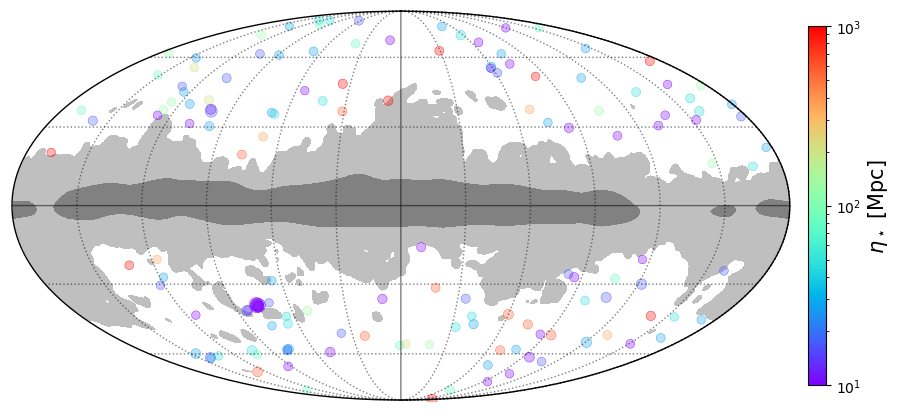

In [132]:
gal90 = hp.read_map('/mnt/home/ophilcox/ceph/planck_pr3_raw/HFI_Mask_GalPlane-apo0_2048_R2.00.fits',field=5)

# sz_cut = np.zeros(len(sz_mask),dtype=float)
sz_cut[gal90==0] = 50
sz_cut[(sz_mask==0)*(gal90!=0)] = 25
hp.mollview(sz_cut+gal90,max=100, #coord=["G", "E"],
            cmap=cm.gray_r,cbar=False,notext=True,title='')
hp.graticule(dpar=30.,dmer=30.,alpha=0.5)

cval = np.log10(png_cat_proc.catalogue['eta_star'])
hp.projscatter(png_cat_proc.catalogue['lon'],
               png_cat_proc.catalogue['lat'],
               #coord=["G", "E"],
               facecolor='none',
               edgecolor=cm.rainbow((cval-cval.min())/(cval.max()-cval.min())),
               lw=0.3,alpha=0.9,
               s=png_cat_proc.catalogue['q_opt']**2*1.5,
               lonlat=True)#,marker='o',linewidths=0.01,ls='')#,c='r')
hp.projscatter(png_cat_proc.catalogue['lon'],
               png_cat_proc.catalogue['lat'],
               #coord=["G", "E"],
               facecolor=cm.rainbow((cval-cval.min())/(cval.max()-cval.min())),
               edgecolor='none',
               lw=0.3,alpha=0.3,
               s=png_cat_proc.catalogue['q_opt']**2*1.5,
               lonlat=True)
plt.scatter(-1+0.*cval,-1+0.*cval,c=10**cval,s=0,cmap=cm.rainbow,norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar(fraction=0.022, pad=0.02)
#cbar.set_ticks(10,1000)
cbar.set_label(r'$\eta_\star$ [$\mathrm{Mpc}$]',fontsize=15);
plt.savefig('pub_plots/detections_scatter.pdf',bbox_inches='tight')

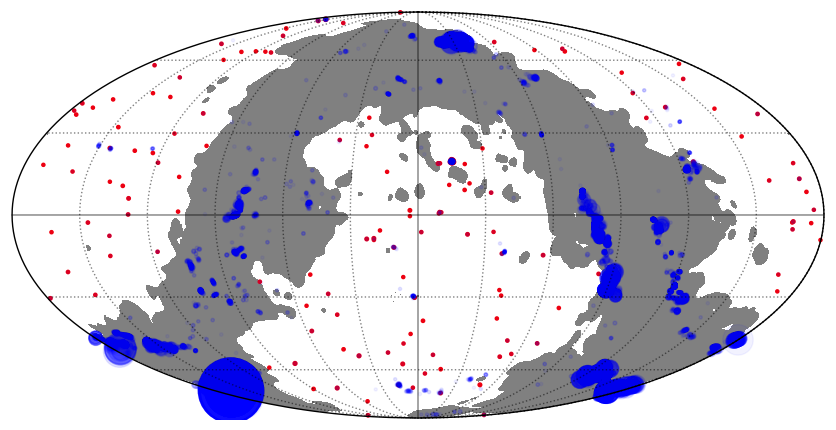

In [133]:
sz_cut = np.zeros(len(sz_mask),dtype=float)
sz_cut[sz_mask==0] = np.nan
hp.mollview(sz_cut,max=100, coord=["G", "E"],cmap=cm.gray_r,cbar=False,notext=True,title='')
ss = 5
hp.graticule(dpar=30.,dmer=30.,alpha=0.5)
hp.projscatter(png_cat_proc.catalogue['lon'][png_cat_proc.catalogue['q_opt']>ss],
               png_cat_proc.catalogue['lat'][png_cat_proc.catalogue['q_opt']>ss],
               coord=["G", "E"], s=png_cat_proc.catalogue['q_opt'][png_cat_proc.catalogue['q_opt']>ss]**2/ss,lonlat=True,c='r')
hp.projscatter(png_cat.catalogue['lon'][png_cat.catalogue['q_opt']>ss],
               png_cat.catalogue['lat'][png_cat.catalogue['q_opt']>ss],
               coord=["G", "E"], s=png_cat.catalogue['q_opt'][png_cat.catalogue['q_opt']>ss]**2/ss,lonlat=True,c='b',alpha=0.05)
#hp.projscatter(nt_official['lon'],nt_official['lat'],s=3,lonlat=True)

In [134]:
# merge_only = merge_cat(cut_on_map(png_cat,sz_mask),0.2)

In [135]:
# merge_only = merge_cat(png_cat,0.2)

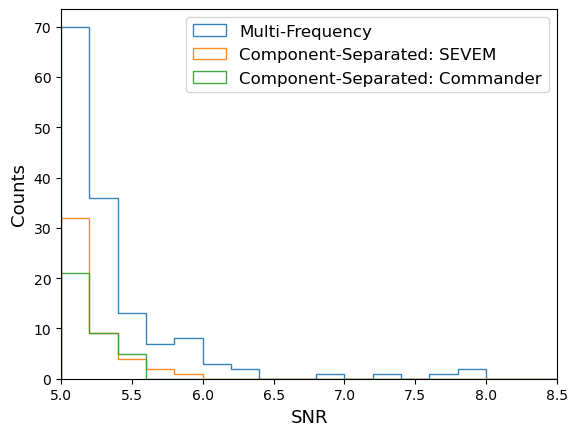

In [136]:
plt.hist(png_cat_proc.catalogue['q_opt'],label=r'Multi-Frequency',alpha=0.9,bins=50,range=[5,15],histtype='step')
plt.hist(png_cat_proc_sep.catalogue['q_opt'],label=r'Component-Separated: SEVEM',alpha=0.9,bins=50,range=[5,15],histtype='step')
plt.hist(png_cat_proc_sepC.catalogue['q_opt'],label=r'Component-Separated: Commander',alpha=0.9,bins=50,range=[5,15],histtype='step')
plt.legend(fontsize=12);
plt.xlim(5,8.5)
plt.xlabel(r'SNR',fontsize=13);
plt.ylabel(r'Counts',fontsize=13);
plt.savefig('pub_plots/detections_pdf.pdf',bbox_inches='tight')

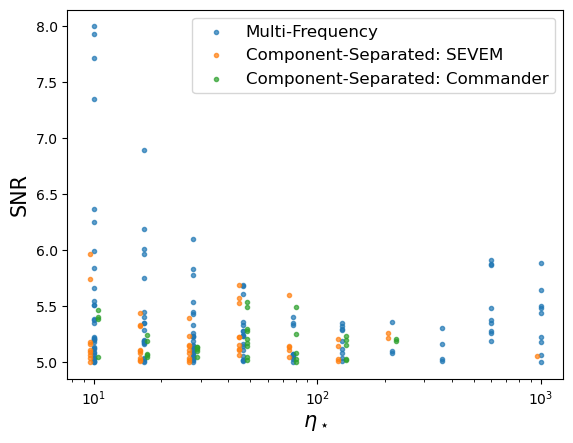

In [137]:
plt.scatter(png_cat_proc.catalogue['eta_star'],png_cat_proc.catalogue['q_opt'],marker='.',alpha=0.7,label=r'Multi-Frequency')
plt.scatter(png_cat_proc_sep.catalogue['eta_star']*0.96,png_cat_proc_sep.catalogue['q_opt'],marker='.',alpha=0.7,label=r'Component-Separated: SEVEM')
plt.scatter(png_cat_proc_sepC.catalogue['eta_star']*1.04,png_cat_proc_sepC.catalogue['q_opt'],marker='.',alpha=0.7,label=r'Component-Separated: Commander')
plt.xscale('log')
plt.xlabel(r'$\eta_\star$',fontsize=15)
plt.ylabel(r'SNR',fontsize=15);
plt.legend(fontsize=12);

In [138]:
# # Load dipole
# dipole_map = hp.ud_grade(hp.read_map('/mnt/home/ophilcox/ceph/planck_npipe/commander/dipole_CMB_n4096_K.fits',field=[0]),2048)

# sim_dir = '/mnt/home/ophilcox/ceph/planck_pr4_freq/'

# freqs = ['100','143','217','353','545','857']

# # Load frequency maps
# print("Loading frequency maps")
# freq_maps = []
# for f in range(len(freqs)):
#     freq_maps.append(hp.read_map(sim_dir+'planck/npipe6v20_%s_map.fits'%(freqs[f]),field=0)-dipole_map)

# all_point = hp.ud_grade(hp.read_map(sim_dir+'planck/point_mask_snr10.fits'),2048)

## we should add SNR plot to this for best detection!!!

In [139]:
high_snrs = np.where(png_cat_proc.catalogue['q_opt']>6)[0]
pix_ids = png_cat_proc.catalogue['pixel_ids'][high_snrs]

lons = png_cat_proc.catalogue['lon'][high_snrs]
lats = png_cat_proc.catalogue['lat'][high_snrs]
th_x = png_cat_proc.catalogue['theta_x'][high_snrs]
th_y = png_cat_proc.catalogue['theta_y'][high_snrs]

In [140]:
cens = []
all_pix = np.asarray(np.unique(pix_ids),dtype='int')
for pix in all_pix:
    cens.append([np.mean(lons[pix_ids==pix]),np.mean(lats[pix_ids==pix])])

### 153 has a point source???

### check SNR?

### 581 excluded by compsep common mask, and compsep inpainting mask, and also not in GAL040
### 153, 581, 699 not in GAL020 (not particularly useful)
### 599 has PCNT within 4.3', 631 has PCNT within 9' (non-thermal sources)
### no galactic cold cores, no high-reshift source candidates, no SZ candidates

In [34]:
cc = png_cat_proc.catalogue
lon = cc['lon']
lat = cc['lat']
snr = cc['q_opt']
g = cc['y0']
eta_star = cc['eta_star']
eta_hs = cc['eta_hs']
p = cc['pixel_ids']
ind = np.argsort(snr)[::-1]
for i in range(len(lon)):
    if snr[ind][i]<6: break
    d = np.load('model_soubhik_eta(%.2f,%.2f)_l3500_k(0.00,1.00,20).npy'%(eta_star[ind][i],eta_hs[ind][i]))
    print(snr[ind][i],p[ind][i],g[ind][i]*np.max(np.abs(d))*1e6*2.73)

7.995420174260432 599.0 44.78215431492385
7.923648889954722 599.0 56.197183141510784
7.713261765387949 599.0 49.281556335528464
7.349142928897627 599.0 41.16237115140323
6.895720677621409 153.0 29.88243526558694
6.369667247491795 599.0 77.17468236446597
6.252296660004773 599.0 35.01896182421903
6.186537754713349 581.0 47.93165050377181
6.102281446143025 699.0 36.99826586221772
6.012225528439571 631.0 34.77197398589638


In [35]:
cc = png_cat_proc.catalogue
lon = cc['lon']
lat = cc['lat']
snr = cc['q_opt']
g = cc['y0']
eta_star = cc['eta_star']
eta_hs = cc['eta_hs']
ind = np.argsort(snr)[::-1]
for i in range(len(lon)):
    if snr[ind][i]<6: break
    print("%.1f&%.1f&%.1f&%d&%.1f&%.1f\\\\"%(snr[ind][i],lon[ind][i],lat[ind][i],g[ind][i],eta_star[ind][i],eta_hs[ind][i]))

8.0&76.7&-38.6&631&10.0&272.2\\
7.9&77.8&-38.1&692&10.0&277.7\\
7.7&78.0&-38.9&651&10.0&275.9\\
7.3&77.1&-38.1&580&10.0&272.2\\
6.9&100.3&36.3&98&16.7&266.8\\
6.4&77.4&-39.1&698&10.0&288.6\\
6.3&76.8&-38.9&494&10.0&272.2\\
6.2&238.3&-30.0&134&16.7&281.9\\
6.1&239.3&-54.6&34&27.8&257.7\\
6.0&84.8&-40.7&114&16.7&266.8\\


In [37]:
x = cut_on_map(png_cat_proc, compsep)
print(x.catalogue['pixel_ids'][x.catalogue['q_opt']>6])

[153. 581. 599. 631. 699.]


In [38]:
x = png_cat_proc
print(x.catalogue['pixel_ids'][x.catalogue['q_opt']>6])

[153. 581. 599. 599. 599. 599. 599. 599. 631. 699.]


### Check against catalogs

In [39]:
lons = png_cat_proc.catalogue['lon'][high_snrs] # [77.5]
lats = png_cat_proc.catalogue['lat'][high_snrs] #[-38.5]

In [44]:
freqs = ['100','143','217','353','545','857']

In [45]:
cat = fits.open('/mnt/home/ophilcox/szifi/COM_PCCS_PCNT_R2.00.fits')[1].data

for i in range(len(lons)):
    dis = hp.rotator.angdist([lons[i],lats[i]],[cat['GLON'],cat['GLAT']],lonlat=True)
    nearest = np.min(dis)*180./np.pi*60.
    if nearest<10.:
        print("Nearest @ %.1f arcmin on pixel %d"%(nearest,png_cat_proc.catalogue['pixel_ids'][high_snrs][i]))
        print(cat['GLON'][np.argmin(dis)],cat['GLAT'][np.argmin(dis)])

Nearest @ 4.3 arcmin on pixel 599
77.762 -38.034
Nearest @ 8.9 arcmin on pixel 631
84.918 -40.842


In [46]:
cat = fits.open('/mnt/home/ophilcox/szifi/HFI_PCCS_SZ-union_R2.08.fits')[1].data

for i in range(len(lons)):
    dis = hp.rotator.angdist([lons[i],lats[i]],[cat['GLON'],cat['GLAT']],lonlat=True)
    nearest = np.min(hp.rotator.angdist([lons[i],lats[i]],[cat['GLON'],cat['GLAT']],lonlat=True))*180./np.pi*60.
    if nearest<10.:
        print("Nearest @ %.1f arcmin on pixel %d"%(nearest,png_cat_proc.catalogue['pixel_ids'][high_snrs][i]))
        print(cat['GLON'][np.argmin(dis)],cat['GLAT'][np.argmin(dis)])

In [47]:
cat = fits.open('/mnt/home/ophilcox/szifi/HFI_PCCS_HZ_R2.00.fits')[1].data

for i in range(len(lons)):
    dis = hp.rotator.angdist([lons[i],lats[i]],[cat['GLON'],cat['GLAT']],lonlat=True)
    nearest = np.min(hp.rotator.angdist([lons[i],lats[i]],[cat['GLON'],cat['GLAT']],lonlat=True))*180./np.pi*60.
    if nearest<10.:
        print("Nearest @ %.1f arcmin on pixel %d"%(nearest,png_cat_proc.catalogue['pixel_ids'][high_snrs][i]))
        print(cat['GLON'][np.argmin(dis)],cat['GLAT'][np.argmin(dis)])

In [48]:
for f in freqs:
    cat = fits.open('/mnt/home/ophilcox/szifi/COM_PCCS_%s_R2.01.fits'%f)[1].data

    for i in range(len(lons)):
        dis = hp.rotator.angdist([lons[i],lats[i]],[cat['GLON'],cat['GLAT']],lonlat=True)
        nearest = np.min(hp.rotator.angdist([lons[i],lats[i]],[cat['GLON'],cat['GLAT']],lonlat=True))*180./np.pi*60.
        if nearest<10.:
            print("Nearest @ %.1f arcmin on pixel %d"%(nearest,png_cat_proc.catalogue['pixel_ids'][high_snrs][i]))
            print(f,cat['GLON'][np.argmin(dis)],cat['GLAT'][np.argmin(dis)])

In [49]:
cat = fits.open('/mnt/home/ophilcox/szifi/HFI_PCCS_GCC_R2.02.fits')[1].data

for i in range(len(lons)):
    dis = hp.rotator.angdist([lons[i],lats[i]],[cat['GLON'],cat['GLAT']],lonlat=True)
    nearest = np.min(hp.rotator.angdist([lons[i],lats[i]],[cat['GLON'],cat['GLAT']],lonlat=True))*180./np.pi*60.
    if nearest<10.:
        print("Nearest @ %.1f arcmin on pixel %d"%(nearest,png_cat_proc.catalogue['pixel_ids'][high_snrs][i]))
        print(cat['GLON'][np.argmin(dis)],cat['GLAT'][np.argmin(dis)])

In [56]:
point5 = load_point_catalog(snr_min=4)

for i in range(len(lons)):
    for j in range(len(point5)):
        dis = hp.rotator.angdist([lons[i],lats[i]],[point5[j].catalogue['lon'],point5[j].catalogue['lat']],lonlat=True)
        nearest = np.min(hp.rotator.angdist([lons[i],lats[i]],[point5[j].catalogue['lon'],point5[j].catalogue['lat']],lonlat=True))*180./np.pi*60.
        if nearest<15.:
            print("Nearest @ %.1f arcmin on pixel %d / lat=%.2f"%(nearest,png_cat_proc.catalogue['pixel_ids'][high_snrs][i],png_cat_proc.catalogue['lat'][high_snrs][i]))
            print(point5[j].catalogue['lon'][np.argmin(dis)],point5[j].catalogue['lat'][np.argmin(dis)],point5[j].catalogue['q_opt'][np.argmin(dis)])


Found 3066 point sources in freq-0 from 770 catalogues
Found 3066 point sources in freq-0 clusters after SNR=4.0 cut

Found 5524 point sources in freq-1 from 770 catalogues
Found 5524 point sources in freq-1 clusters after SNR=4.0 cut

Found 14264 point sources in freq-2 from 770 catalogues
Found 14264 point sources in freq-2 clusters after SNR=4.0 cut

Found 18855 point sources in freq-3 from 770 catalogues
Found 18855 point sources in freq-3 clusters after SNR=4.0 cut

Found 26871 point sources in freq-4 from 770 catalogues
Found 26871 point sources in freq-4 clusters after SNR=4.0 cut

Found 37547 point sources in freq-5 from 770 catalogues
Found 37547 point sources in freq-5 clusters after SNR=4.0 cut
Nearest @ 12.9 arcmin on pixel 153 / lat=36.32
100.52215685629783 36.470861238080005 5.435203515063425
Nearest @ 12.6 arcmin on pixel 599 / lat=-38.90
76.59138273609682 -38.83929391424522 4.483569722070366
Nearest @ 11.8 arcmin on pixel 599 / lat=-38.90
76.6099055164806 -38.839610114

In [57]:
sz_all = load_sz_catalog()

for i in range(len(lons)):
    dis = hp.rotator.angdist([lons[i],lats[i]],[sz_all.catalogue['lon'],sz_all.catalogue['lat']],lonlat=True)
    nearest = np.min(dis)*180./np.pi*60.
    if nearest<10.:
        print("Nearest @ %.1f arcmin on pixel %d"%(nearest,png_cat_proc.catalogue['pixel_ids'][high_snrs][i]))
        print(sz_all.catalogue['lon'][np.argmin(dis)],sz_all.catalogue['lat'][np.argmin(dis)])

Found 5433 SZ clusters (SNR>4) from 770 catalogues


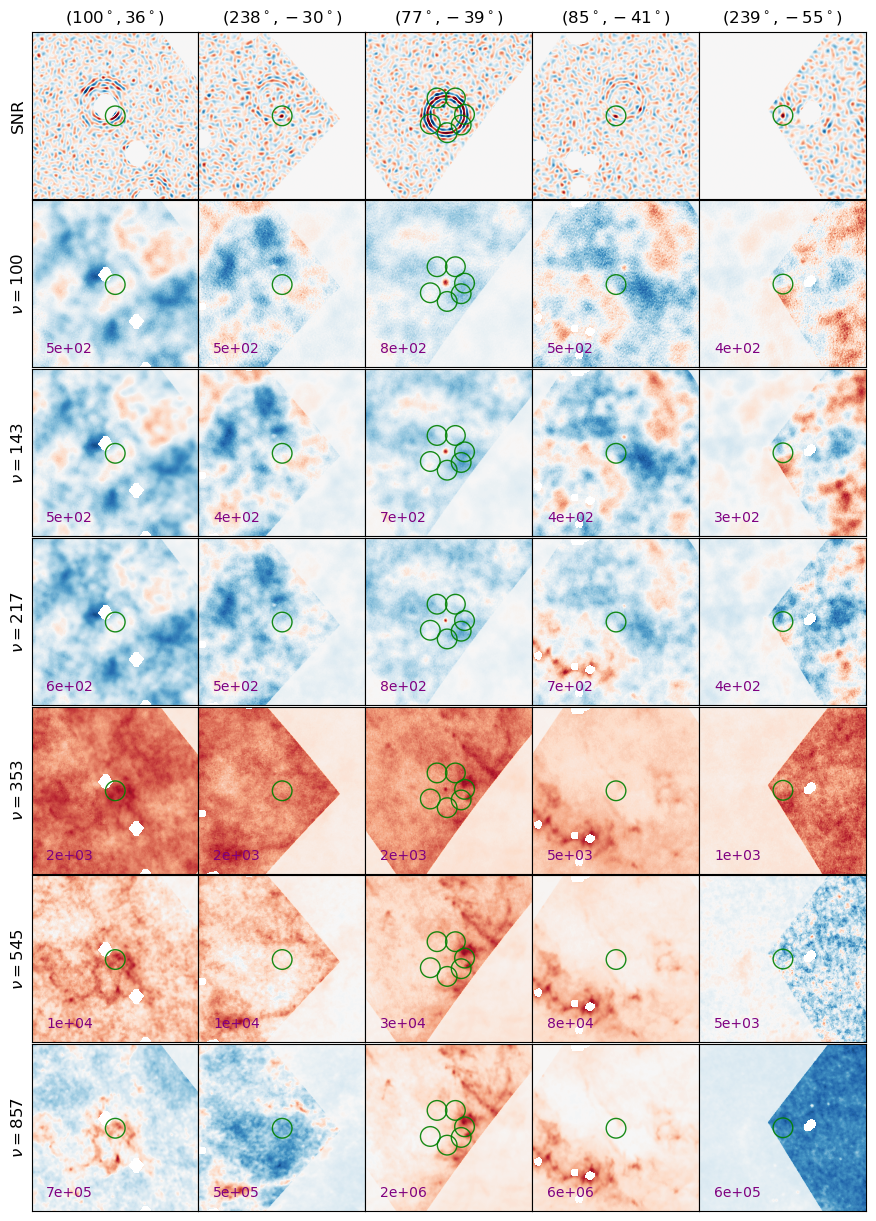

In [951]:
def add_colorbar(mappable):
    # from mpl_toolkits.axes_grid1 import make_axes_locatable
    # import matplotlib.pyplot as plt
    # last_axes = plt.gca()
    # ax = mappable.axes
    # fig = ax.figure
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.0)
    # cbar = fig.colorbar(mappable, cax=cax)
    # plt.sca(last_axes)
    # return cbar
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    ax = mappable.axes
    axins = inset_axes(ax,
                    width="5%",  
                    height="100%",
                    loc='center left',
                    borderpad=-5
                   )
    fig.colorbar(im, cax=axins)#, orientation="vertical")

    
fig,ax = plt.subplots(7,len(np.unique(pix_ids)),sharex=True,sharey=True,figsize=(14/1.3,2*len(pix_ids)/1.3))
fig.subplots_adjust(wspace=0.0,hspace=-0.02)
p1,p2 = 128,-128
q1,q2 = 128,-128

# max_dat = []
# for i in range(6):
#     maxs = []
#     for j,pix in enumerate(np.unique(pix_ids)):
#         dat = np.load('/mnt/home/ophilcox/ceph/szifi_cutouts/planck_cleaned/planck_field_%d_tmap.npy'%pix)*1e6
#         mask = np.load('/mnt/home/ophilcox/ceph/szifi_cutouts/planck_cleaned/planck_field_%d_mask.npy'%pix)
#         snr = np.load('/mnt/home/ophilcox/ceph/szifi_cutouts/planck_cleaned/snr_maps/planck_visual%d_q_0_0.npy'%pix)
#         maxs.append(np.max(np.abs(dat[0][:,:,i]*mask[1]*mask[2]*mask[0])))
#     max_dat.append(np.max(maxs)*0.5)

fs = 12
for j,pix in enumerate(np.unique(pix_ids)):
    dat = np.load('/mnt/home/ophilcox/ceph/szifi_cutouts/planck_cleaned/planck_field_%d_tmap.npy'%pix)*1e6
    mask = np.load('/mnt/home/ophilcox/ceph/szifi_cutouts/planck_cleaned/planck_field_%d_mask.npy'%pix)
    snr = np.load('/mnt/home/ophilcox/ceph/szifi_cutouts/planck_cleaned/snr_maps/planck_visual%d_q_0_0.npy'%pix)
    
    points_x = th_x[pix_ids==pix]/(14.8*np.pi/180/1024.)-0.5
    points_y = 1024-th_y[pix_ids==pix]/(14.8*np.pi/180/1024.)-0.5
    #print(pix, png_cat_proc.catalogue['eta_star'][high_snrs][pix_ids==pix],png_cat_proc.catalogue['eta_hs'][high_snrs][pix_ids==pix])
    
    dat[0,mask[1]==0] = np.inf
    dat[0,mask[0]==0] = np.inf
        
    p1 = int(points_x.mean())-173
    p2 = int(points_x.mean())+173
    q1 = int(points_y.mean())-173
    q2 = int(points_y.mean())+173
        
    im=ax[0,j].imshow(snr[q1:q2,p1:p2],vmax=5,vmin=-5,cmap=cm.RdBu_r)
    #if j==len(np.unique(pix_ids))-1:
    #    add_colorbar(im)#fig.colorbar(cax)
        
    if j==0: ax[0,j].set_ylabel(r'SNR',fontsize=fs)
    lonlat = png_cat_proc.catalogue['lon'][high_snrs][pix_ids==pix].mean(),png_cat_proc.catalogue['lat'][high_snrs][pix_ids==pix].mean()
    ax[0,j].set_title(r'$(%.0f^\circ, %.0f^\circ)$'%(lonlat[0],lonlat[1]),fontsize=fs)
        
    for i in range(6):
        fmap = (dat[0,:,:,i]*(mask[2]!=0))[q1:q2,p1:p2]
        vmax = np.max(np.abs(fmap),where=np.isfinite(fmap),initial=0)*1.1
        ax[i+1,j].text(30,173*2-30,"%.0e"%vmax,color='purple')
        im=ax[i+1,j].imshow((dat[0,:,:,i]*((mask[2]!=0)+0.2*(mask[2]==0)))[q1:q2,p1:p2],cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
        ax[i+1,j].set_xticks([],[])
        ax[i+1,j].set_yticks([],[])
        if j==0:
            ax[i+1,j].set_ylabel(r'$\nu = %s$'%freqs[i],fontsize=fs)
        #if j==len(np.unique(pix_ids))-1:
        #    add_colorbar(im)
        
    for i in range(7):
        ax[i,j].scatter(points_x-p1,points_y-q1, marker='o', s=200, edgecolor='green', facecolor='none',alpha=0.9)
fig.savefig('pub_plots/visual_inspection.pdf',bbox_inches='tight');

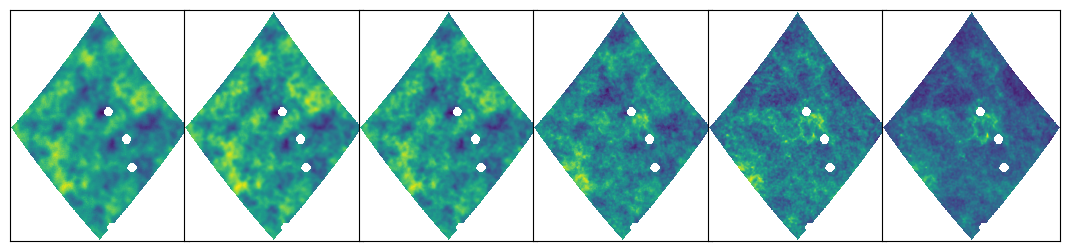

In [340]:
for pix in np.unique(pix_ids[:1]):
    dat = np.load('/mnt/home/ophilcox/ceph/szifi_cutouts/planck_cleaned/planck_field_%d_tmap.npy'%pix)
    mask = np.load('/mnt/home/ophilcox/ceph/szifi_cutouts/planck_cleaned/planck_field_%d_mask.npy'%pix)
    fig,ax = plt.subplots(1,6,figsize=(15,3),sharex=True,sharey=True)
    fig.subplots_adjust(wspace=-0.4,hspace=0.)
    for i in range(6):
        infmap = np.zeros_like(mask[0])
        infmap[mask[2]==0] = np.inf
        infmap[mask[1]==0] = np.inf
        infmap[mask[0]==0] = np.inf
        p1,p2 = (np.where(np.sum(infmap==np.inf,axis=0)!=len(infmap))[0])[[0,-1]]
        q1,q2 = (np.where(np.sum(infmap==np.inf,axis=1)!=len(infmap))[0])[[0,-1]]
        ax[i].imshow((dat[0,:,:,i]+infmap)[q1:q2,p1:p2])
        ax[i].set_xticks([],[])
        ax[i].set_yticks([],[])

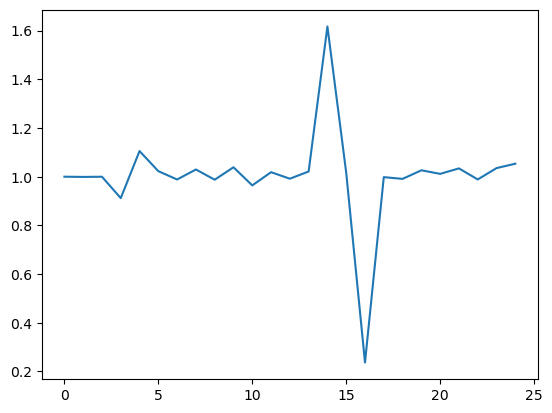

In [125]:
slon, slat = png_cat_proc_sep.catalogue['lon'],png_cat_proc_sep.catalogue['lat']

ratios = []
snrs = []
for i in range(len(slon)):
    dis = hp.rotator.angdist((slon[i],slat[i]),
                             (png_cat_proc.catalogue['lon'],png_cat_proc.catalogue['lat']),
                             lonlat=True)
    if min(dis)*180./np.pi*60.<10.:
        ratios.append([png_cat_proc_sep.catalogue['y0'][i]/png_cat_proc.catalogue['y0'][np.argmin(dis)]])
        snrs.append(png_cat_proc_sep.catalogue['y0'][i])

plt.plot(ratios)

### should note if we actually kill any detections from point / SZ cuts!

In [248]:
test_ang = hp.pix2ang(4096, np.random.randint(0,hp.nside2npix(4096),size=1000),lonlat=True)
test_cat = szifi.cat.cluster_catalogue()
test_cat.catalogue['lon'] = test_ang[0]
test_cat.catalogue['lat'] = test_ang[1]
test_cat.catalogue['q_opt'] = np.random.randn(len(test_ang[0]))*test_ang[1]
test_cat.catalogue['eta_star'] = 100.+0.*test_ang[1]


print(len(test_cat.catalogue['q_opt']))
test_cat = cut_on_map(test_cat, sz_mask)
print(len(test_cat.catalogue['q_opt']))
test_cat = remove_point_sources(test_cat, exclusion_factor=5)
print(len(test_cat.catalogue['q_opt']))
test_cat = remove_cat(test_cat, sz_cat_nopoint.catalogue, dis_arcmin=10)
print(len(test_cat.catalogue['q_opt']))
test_cat = merge_cat(test_cat, 0.2, False)
print(len(test_cat.catalogue['q_opt']/len(test_ang[0])))

1000
572
570
569
Finished in 2 iterations
562


In [249]:
# plt.hist(cut_on_map(png_cat_proc,gal70).catalogue['q_opt'],label=r'70',alpha=0.5,bins=25)#,range=[5,30])
# plt.hist(cut_on_map(png_cat_proc,gal60).catalogue['q_opt'],label=r'60',alpha=0.5,bins=25)#,range=[5,30])
# plt.hist(cut_on_map(png_cat_proc,gal40).catalogue['q_opt'],label=r'40',alpha=0.5,bins=25)#,range=[5,30])
# plt.legend(fontsize=12);
# plt.xlabel(r'SNR',fontsize=12);

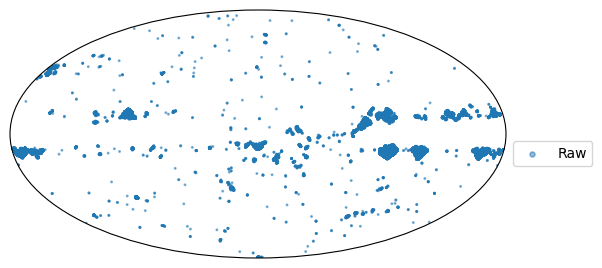

In [943]:
def plot_cat(cat, ssig,label,size=1, alpha=1):
    lat = cat.catalogue['lat'][cat.catalogue['q_opt']>ssig]
    lon = cat.catalogue['lon'][cat.catalogue['q_opt']>ssig]
    snr = cat.catalogue['q_opt'][cat.catalogue['q_opt']>ssig]
    ax.scatter(np.radians(lon-180),np.radians(lat),s=5*size*(snr/ssig)**1,alpha=alpha,label=label)

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

snr_min = 4

plot_cat(png_cat, snr_min, 'Raw', alpha=0.5,size=0.2)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([]);
ax.legend(bbox_to_anchor=(1.,0.5),ncol=1);

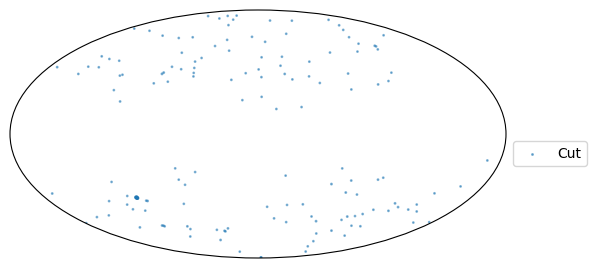

In [944]:
def plot_cat(cat, ssig,label,size=1, alpha=1):
    lat = cat.catalogue['lat'][cat.catalogue['q_opt']>ssig]
    lon = cat.catalogue['lon'][cat.catalogue['q_opt']>ssig]
    snr = cat.catalogue['q_opt'][cat.catalogue['q_opt']>ssig]
    ax.scatter(np.radians(lon-180),np.radians(lat),s=5*size*(snr/ssig)**1,alpha=alpha,label=label)

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')

snr_min = 5

plot_cat(png_cat_proc, snr_min, 'Cut', alpha=0.5,size=0.2)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([]);
ax.legend(bbox_to_anchor=(1.,0.5),ncol=1);

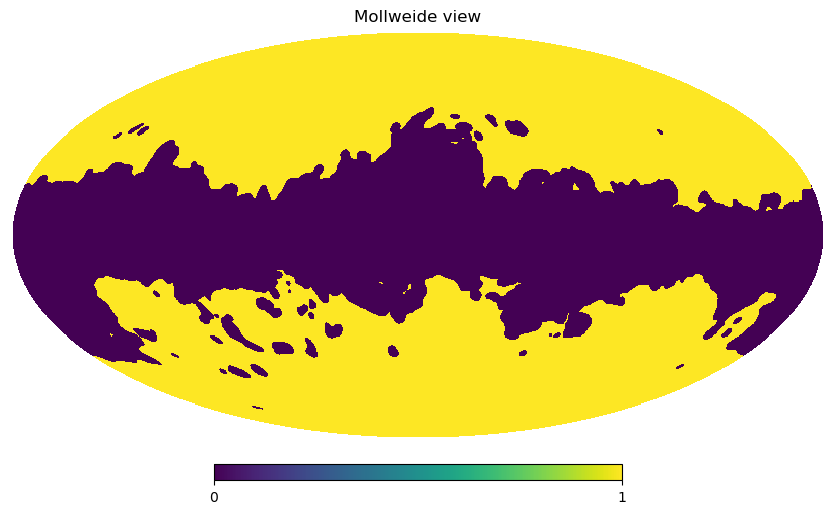

In [355]:
hp.mollview(sz_mask)
ss = 10
hp.projscatter(png_cat_proc.catalogue['lon'][png_cat_proc.catalogue['q_opt']>ss],png_cat_proc.catalogue['lat'][png_cat_proc.catalogue['q_opt']>ss],s=3,lonlat=True,c='r')
#hp.projscatter(nt_official['lon'],nt_official['lat'],s=3,lonlat=True)

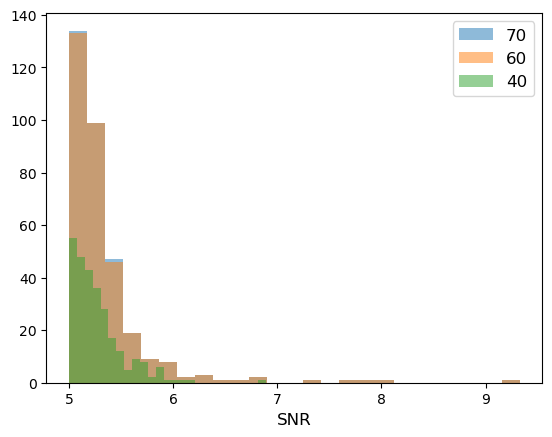

In [356]:
plt.hist(cut_on_map(png_cat_proc,gal70).catalogue['q_opt'],label=r'70',alpha=0.5,bins=25)#,range=[5,30])
plt.hist(cut_on_map(png_cat_proc,gal60).catalogue['q_opt'],label=r'60',alpha=0.5,bins=25)#,range=[5,30])
plt.hist(cut_on_map(png_cat_proc,gal40).catalogue['q_opt'],label=r'40',alpha=0.5,bins=25)#,range=[5,30])
plt.legend(fontsize=12);
plt.xlabel(r'SNR',fontsize=12);

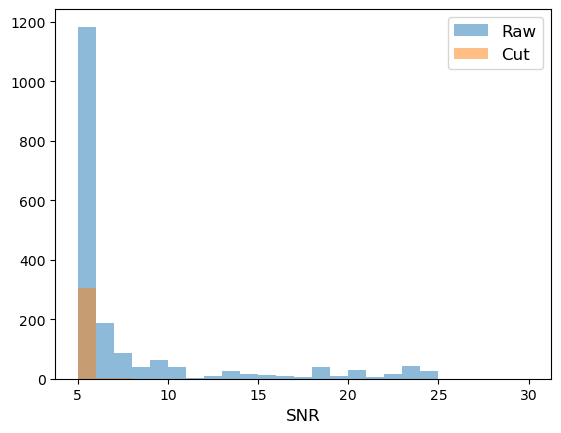

In [344]:
plt.hist(cut_on_map(png_cat,gal70).catalogue['q_opt'],label=r'Raw',alpha=0.5,bins=25,range=[5,30])
plt.hist(png_cat_proc.catalogue['q_opt'],label=r'Cut',alpha=0.5,bins=25,range=[5,30])
plt.legend(fontsize=12);
plt.xlabel(r'SNR',fontsize=12);

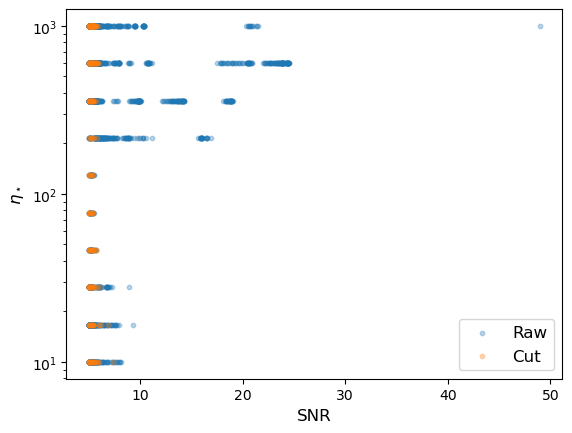

In [346]:
plt.figure()
plt.scatter(cut_on_map(png_cat,gal70).catalogue['q_opt'],cut_on_map(png_cat,gal70).catalogue['eta_star'],alpha=0.3,s=10,label='Raw')
plt.scatter(png_cat_proc.catalogue['q_opt'],png_cat_proc.catalogue['eta_star'],alpha=0.3,s=10,label='Cut')
plt.yscale('log');
plt.legend(fontsize=12);
plt.xlabel(r'SNR',fontsize=12);
plt.ylabel(r'$\eta_\star$',fontsize=12);

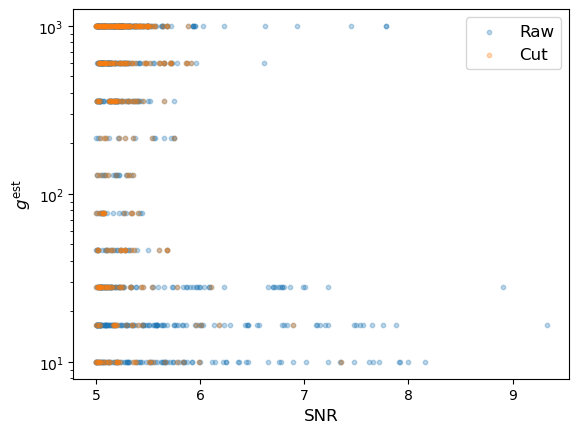

In [347]:
plt.figure()
plt.scatter(cut_on_map(png_cat,gal60).catalogue['q_opt'],cut_on_map(png_cat,gal60).catalogue['eta_star'],alpha=0.3,s=10,label='Raw')
plt.scatter(png_cat_proc.catalogue['q_opt'],png_cat_proc.catalogue['eta_star'],alpha=0.3,s=10,label='Cut')
plt.yscale('log');
plt.legend(fontsize=12);
plt.xlabel(r'SNR',fontsize=12);
plt.ylabel(r'$g^{\rm est}$',fontsize=12);

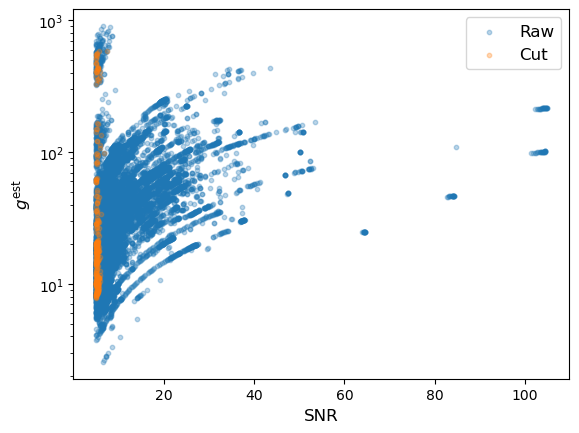

In [348]:
plt.figure()
plt.scatter(png_cat.catalogue['q_opt'],png_cat.catalogue['y0'],alpha=0.3,s=10,label='Raw')
plt.scatter(png_cat_proc.catalogue['q_opt'],png_cat_proc.catalogue['y0'],alpha=0.3,s=10,label='Cut')
plt.yscale('log');
plt.legend(fontsize=12);
plt.xlabel(r'SNR',fontsize=12);
plt.ylabel(r'$g^{\rm est}$',fontsize=12);

### Error distribution

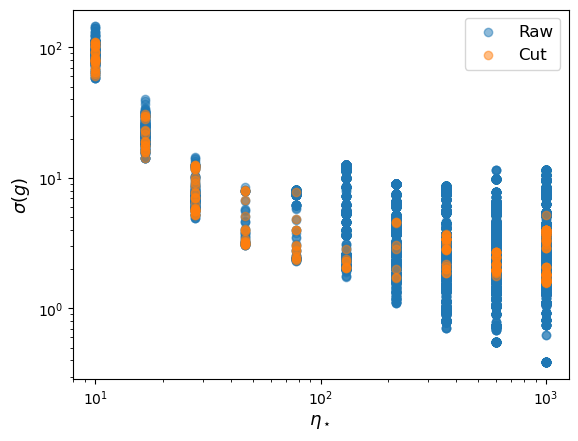

In [349]:
plt.scatter(png_cat.catalogue['eta_star'],png_cat.catalogue['y0']/png_cat.catalogue['q_opt'],alpha=0.5,label='Raw')
plt.scatter(png_cat_proc.catalogue['eta_star'],png_cat_proc.catalogue['y0']/png_cat_proc.catalogue['q_opt'],alpha=0.5,label='Cut')
plt.xlabel(r'$\eta_\star$',fontsize=13);
plt.ylabel(r'$\sigma(g)$',fontsize=13);
plt.legend(fontsize=12);
plt.yscale('log')
plt.xscale('log')

### check backreaction bound?

In [856]:
# png_prep = cut_on_map(load_png_catalog(sep='cv'), sz_mask)
# peta_star = png_prep.catalogue['eta_star']
# psig_g = png_prep.catalogue['y0']/png_prep.catalogue['q_opt']
# sigs_cv = []
# errs_cv = []
# for eta_star in all_eta_star:
#     f = np.where(peta_star==eta_star)[0]
#     sigs_cv.append(psig_g[f].mean())
#     errs_cv.append(psig_g[f].std())

In [869]:
from scipy.interpolate import UnivariateSpline

In [897]:
cv_model = UnivariateSpline(np.log(all_eta_star), np.log(sigs_cv),s=1000000000,k=3)

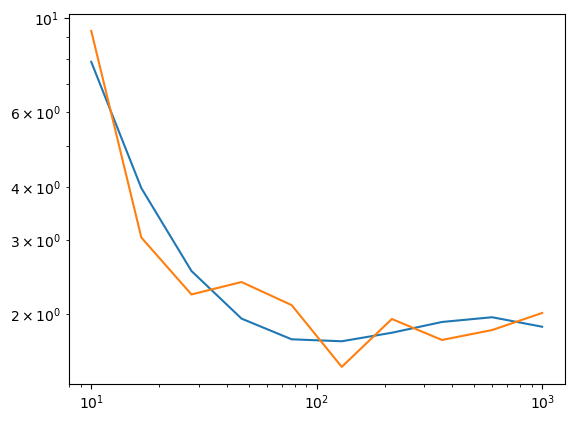

In [898]:
plt.plot(all_eta_star, np.exp(cv_model(np.log(all_eta_star))))
plt.plot(all_eta_star, sigs_cv)
plt.xscale('log')
plt.yscale('log')

Found 8035 PNG hotspots (SNR>4) from 770 catalogues
Found 42973 PNG hotspots (SNR>4) from 770 catalogues


NameError: name 'cv_model' is not defined

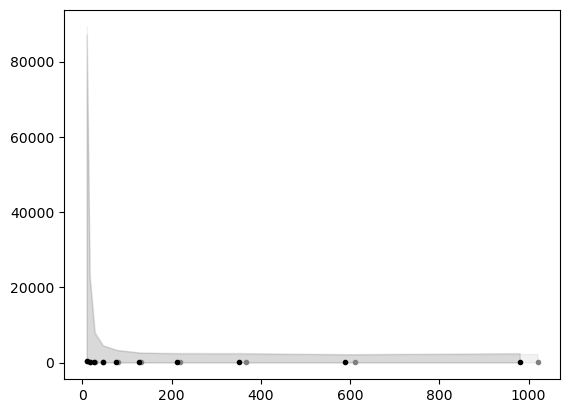

In [141]:
Delta_eta_s = 19
N_spots = lambda g, eta_star, M0_by_H: 4e8*g**(3./2.)*(Delta_eta_s/100.)*(100./eta_star)**3*np.exp(-np.pi*(M0_by_H**2-2.)/58.9**2/g)
backreaction = lambda g, M0_by_H: g/(8.*np.pi**3.)*(g*58.9)**(3./2.)*np.exp(-np.pi*(M0_by_H**2-2)/58.9**2/g)/(58.9**2)

png_prep = cut_on_map(load_png_catalog(sep='sevem'), sz_mask)
peta_star = png_prep.catalogue['eta_star']
psig_g = png_prep.catalogue['y0']/png_prep.catalogue['q_opt']
sigs = []
errs = []
for eta_star in all_eta_star:
    f = np.where(peta_star==eta_star)[0]
    sigs.append(psig_g[f].mean())
    errs.append(psig_g[f].std())
plt.errorbar(all_eta_star*1.02, 5*np.asarray(sigs), yerr=5.*np.asarray(errs), alpha=1, label=r'_$5\,\sigma(g)$', ls='',marker='.', c='gray')

plt.fill_between(all_eta_star*1.02,5*np.asarray(sigs),1000.*np.asarray(sigs),alpha=0.1,color='gray')

png_prep = cut_on_map(load_png_catalog(sep='none'), sz_mask)
peta_star = png_prep.catalogue['eta_star']
psig_g = png_prep.catalogue['y0']/png_prep.catalogue['q_opt']
sigs = []
errs = []
for eta_star in all_eta_star:
    f = np.where(peta_star==eta_star)[0]
    sigs.append(psig_g[f].mean())
    errs.append(psig_g[f].std())
plt.errorbar(all_eta_star*0.98, 5*np.asarray(sigs), yerr=5.*np.asarray(errs), alpha=1, label=r'$5\,\sigma(g)$', ls='',marker='.', c='k')
plt.fill_between(all_eta_star*0.98,5*np.asarray(sigs),1000.*np.asarray(sigs),alpha=0.1,color='k')

# Add CV limit
plt.plot(all_eta_star, 5*np.exp(cv_model(np.log(all_eta_star))), alpha=0.5, ls='--',marker='', c='k')

g_needed = []
M0s = [200,500,1000]
eta_star_all = np.geomspace(min(peta_star)*0.8,max(peta_star)*1.2,1000)
for i in range(len(eta_star_all)):
    g_all = np.geomspace(1e-3,1000,1000)
    g_needed.append([g_all[np.where(N_spots(g_all, eta_star_all[i], M0)>1)[0][0]] for M0 in M0s])

g_back = []
for i in range(len(eta_star_all)):
    g_all = np.geomspace(1e-3,1000,1000)
    g_back.append([g_all[np.where(backreaction(g_all, M0)>0.01)[0][0]] for M0 in M0s])

cs = ['r','b','g','purple']
for i in range(len(M0s)):
    plt.fill_between(eta_star_all,np.asarray(g_needed)[:,i],np.asarray(g_back)[:,i],alpha=0.05,color=cs[i])
    plt.plot(eta_star_all,np.asarray(g_needed)[:,i],label=r'$M_0/H=%d$'%(M0s[i]),alpha=0.5,c=cs[i])
    plt.plot(eta_star_all,np.asarray(g_back)[:,i],alpha=0.5,c=cs[i],ls=':')
plt.ylim(0.5,1000);
plt.yscale('log')
plt.xscale('log')
plt.legend(ncol=2);
plt.xlabel(r'$\eta_\ast$ [Mpc]',fontsize=15);
plt.ylabel(r'$g$',fontsize=15);
plt.xlim(min(eta_star_all),max(eta_star_all))
plt.savefig('pub_plots/exclusion_plot.pdf',bbox_inches='tight')

## Notes:

#### General procedure
- First find all point sources with SNR > 10 in each of the 6 frequency channels. This uses only a galactic mask.
- Create point-source mask, removing any pixels within $3\sigma_{\rm beam}$ of the point sources (for each channel), via a recursive search, using an $N_{\rm side}=4096$ map.
- **TODO**: Check if there's any other holes in the mask! 
- Find the tSZ clusters with 15 values of $\theta_{500}\in[0.5,50]$ arcmin, merging at $10'$ (following 2204.13780, based on 1502.01598), and using an SNR threshold of 5. We fix $\ell\in[100,2500]$ and use one level of recursion to optimize the SNR.
- Reject tSZ if within $5\sigma_{\rm beam}(f)$ of a point-sources at frequency $f$.
- Find the PNG hotspots with 10 values of $\eta_\star$ in $[5,500]$ at fixed $\eta_{\rm HS}=\eta_{\rm rec}$, for SNR of 5, and merging at $10'$. We fix $\ell\in[100,2500]$ and do not use recursion (since the null hypothesis has no clusters).
- Reject the hotspots if (a) within $5\sigma_{\rm beam}(f)$ of a point-sources at frequency $f$, (b) within $10'$ of an SZ cluster, (c) outside the Planck GAL070 map (i.e. in the most dusty 30\%).

#### Testing
- Create a fake map containing $30$ clusters at each of $10$ values of $\eta_\star$, separated by at least $1^\circ$ in the sky.
- Add this to a single FFP10 simulation. 
- Analyze with the above pipeline, testing (a) the recovered values of $g$ and $\eta_\star$, (b) the SNR as a function of $\eta_\star$, (c) the completeness, i.e. the fraction of injected clusters recovered by the pipeline.

#### Some Conclusions
- From the noise distribution, $\sigma(g)>1$ for $\eta_\star\lesssim 20$ Mpc. This is a lower limit on $\eta_\star$ (partly caused by point-source confusion).
- Sources are likely detectable also for $\eta_\star>500$ Mpc, though one must ensure the template is not larger than $7^\circ$ (the projection size).
- For $\eta_\star\gtrsim 50$, $g=1$ clusters are detectable, with a maximum completeness of $\approx 70\%$ (mostly from the mask).
- $\ell_{\rm min}=100$ might be too conservative in practice, and limits the detectability of large templates.
- $g=3$ is too large in this test; it causes significant back-reaction onto the other detections
- **TODO**: Careful of normalization of high-frequency maps!!!
- **TODO**: repeat for component-separated map!
- **TODO**: Add PGCC cold gas clouds??
